In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv
/kaggle/input/who-is-the-real-winner/test.csv


In [2]:
# we shall save the data of train and test data
train_file_path='../input/who-is-the-real-winner/train.csv'
test_file_path='../input/who-is-the-real-winner/test.csv'

X=pd.read_csv(train_file_path,index_col='ID')
X_test=pd.read_csv(test_file_path,index_col='ID')
X.drop(['Candidate', 'Constituency ∇'], axis=1, inplace=True)
X_test.drop(['Candidate', 'Constituency ∇'], axis=1, inplace=True)

y = X.Education
X.drop(['Education'], axis=1, inplace=True)


X.head()

,Party,Criminal Case,Total Assets,Liabilities,state
ID,,,,,
0,DMK,4,211 Crore+,2 Crore+,TAMIL NADU
1,BJP,0,1 Crore+,0,MADHYA PRADESH
2,INC,0,7 Crore+,22 Lac+,KARNATAKA
3,BJP,0,9 Crore+,24 Lac+,BIHAR
4,BJP,2,2 Crore+,61 Lac+,WEST BENGAL


In [3]:
import pandas as pd
import re

def convert_to_numerical(string_value):
    
    unit_conversion = {
        'crore': 1e7,   # 1 crore = 10,000,000
        'crores':1e7,
        'lac': 1e5,     # 1 lakh = 100,000
        'thou': 1e3,
        'hund': 100
    }
    
    if isinstance(string_value, str):
        match = re.match(r'(\d+)\s*(\w+)?', string_value)  
        if match:
            value = float(match.group(1))
            unit = match.group(2).lower() if match.group(2) else None  # Extract the unit if present
            # Convert value to numerical value based on unit
            if unit in unit_conversion:
                return value * unit_conversion[unit]
            else:
                return value
    elif isinstance(string_value, int) or isinstance(string_value, float):
        return string_value  # Return the numeric value directly if it's already numeric
    return None

# Convert string values to numerical values
X['Total Assets'] = X['Total Assets'].apply(convert_to_numerical)
X['Liabilities'] = X['Liabilities'].apply(convert_to_numerical)
X_test['Total Assets'] = X_test['Total Assets'].apply(convert_to_numerical)
X_test['Liabilities'] = X_test['Liabilities'].apply(convert_to_numerical)

X.head()

# y.head()

,Party,Criminal Case,Total Assets,Liabilities,state
ID,,,,,
0,DMK,4,2.110000e+09,20000000.0,TAMIL NADU
1,BJP,0,1.000000e+07,0.0,MADHYA PRADESH
2,INC,0,7.000000e+07,2200000.0,KARNATAKA
3,BJP,0,9.000000e+07,2400000.0,BIHAR
4,BJP,2,2.000000e+07,6100000.0,WEST BENGAL


In [4]:
#lets try with ordinal encoder
# we will encode all the categorical data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_predict

columns_to_encode = ['Party', 'state']

ordinal_encoder_y = OrdinalEncoder()
y_reshaped = y.values.reshape(-1, 1)
y_encoded = ordinal_encoder_y.fit_transform(y_reshaped)

ordinal_encoder = OrdinalEncoder()

# Encode categorical columns
X_encoded = X.copy()
X_test_encoded=X_test.copy()

X_encoded[columns_to_encode] = ordinal_encoder.fit_transform(X[columns_to_encode])
X_test_encoded[columns_to_encode] = ordinal_encoder.fit_transform(X_test[columns_to_encode])

y_encoded_df = pd.DataFrame(y_encoded, columns=['Education'])

y_encoded_df.index=y.index
y_encoded_df.columns = y_encoded_df.columns.astype(str)

# Select numerical columns
num_X = X[['Criminal Case', 'Total Assets', 'Liabilities']]
num_X_test=X_test[['Criminal Case', 'Total Assets', 'Liabilities']]

# Concatenate encoded columns with numerical features
OH_X = pd.concat([num_X, X_encoded[columns_to_encode]], axis=1)
OH_X_test = pd.concat([num_X_test, X_test_encoded[columns_to_encode]], axis=1)

OH_X.index=X.index
OH_X_test.index=X_test.index

OH_X.columns = OH_X.columns.astype(str)
OH_X_test.columns = OH_X_test.columns.astype(str)
OH_X.head()
y_encoded_df.head()

,Education
ID,
0,3.0
1,1.0
2,9.0
3,9.0
4,3.0


In [5]:
# lets solve it by using KNN method
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import  cross_val_score

# Define the pipeline including preprocessing steps and KNN classifier
knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()),                 
    ('knn', KNeighborsClassifier(n_neighbors=29))  
])

# Make predictions on the test data
cv_scores_knn = cross_val_score(knn_pipeline, OH_X, y_encoded_df.values.ravel(), cv=5, scoring='f1_micro')
print("Mean F1 score (KNN):", cv_scores_knn.mean())
print("Standard deviation of F1 scores:", cv_scores_knn.std())

knn_pipeline.fit(OH_X,y_encoded_df.values.ravel())

predictions = knn_pipeline.predict(OH_X_test)

# 4. Create DataFrame with IDs and Predicted Values
results_df = pd.DataFrame({'ID': OH_X_test.index, 'Education': predictions})

results_df.to_csv('submission.csv', index=False)
output_file_path = '/kaggle/working/submission.csv'

# Inverse transform the numerical predictions to get string representations
predicted_labels = ordinal_encoder_y.inverse_transform(predictions.reshape(-1, 1))

# Create DataFrame with IDs and Predicted Values (converted to strings)
results_df = pd.DataFrame({'ID': OH_X_test.index, 'Education': predicted_labels.flatten()})

# Save the DataFrame containing predictions to a CSV file
results_df.to_csv(output_file_path, index=False)

# Print message indicating where the file is saved
print("Predictions saved to:", output_file_path)


Mean F1 score (KNN): 0.23798218883613256
Standard deviation of F1 scores: 0.01232955217368
Predictions saved to: /kaggle/working/submission.csv


In [6]:
X_with_education = X.join(y, how='inner') 
X_with_education.head()

,Party,Criminal Case,Total Assets,Liabilities,state,Education
ID,,,,,,
0,DMK,4,2.110000e+09,20000000.0,TAMIL NADU,8th Pass
1,BJP,0,1.000000e+07,0.0,MADHYA PRADESH,12th Pass
2,INC,0,7.000000e+07,2200000.0,KARNATAKA,Post Graduate
3,BJP,0,9.000000e+07,2400000.0,BIHAR,Post Graduate
4,BJP,2,2.000000e+07,6100000.0,WEST BENGAL,8th Pass


/tmp/ipykernel_33/4212386882.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  criminal_candidates['Criminal Case Percentage'] = (


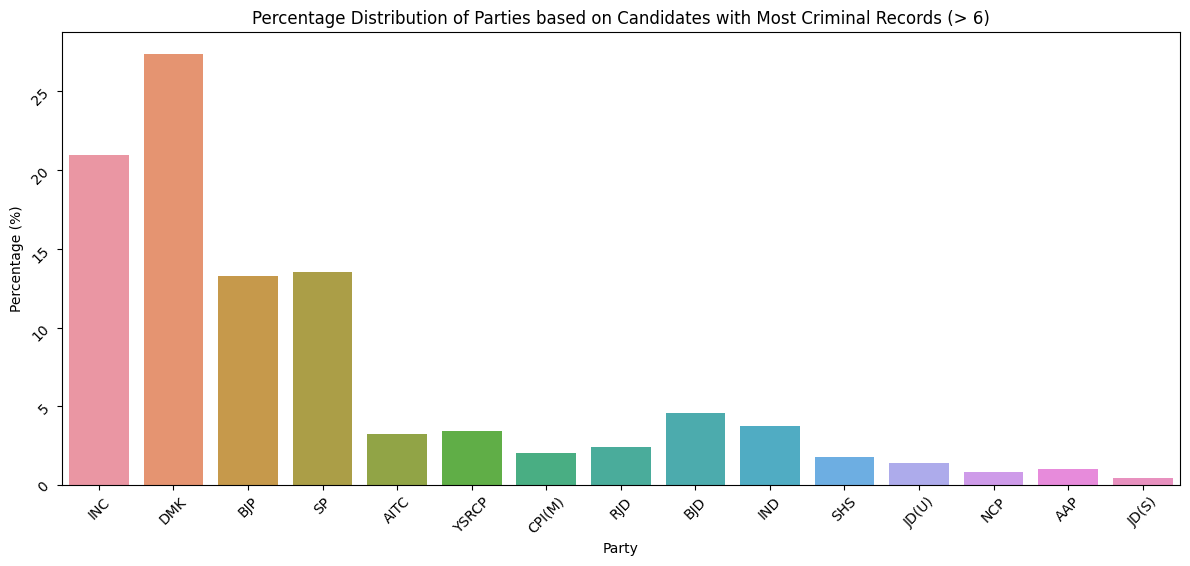

/tmp/ipykernel_33/4212386882.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wealthy_candidates['Total Assets Percentage'] = (


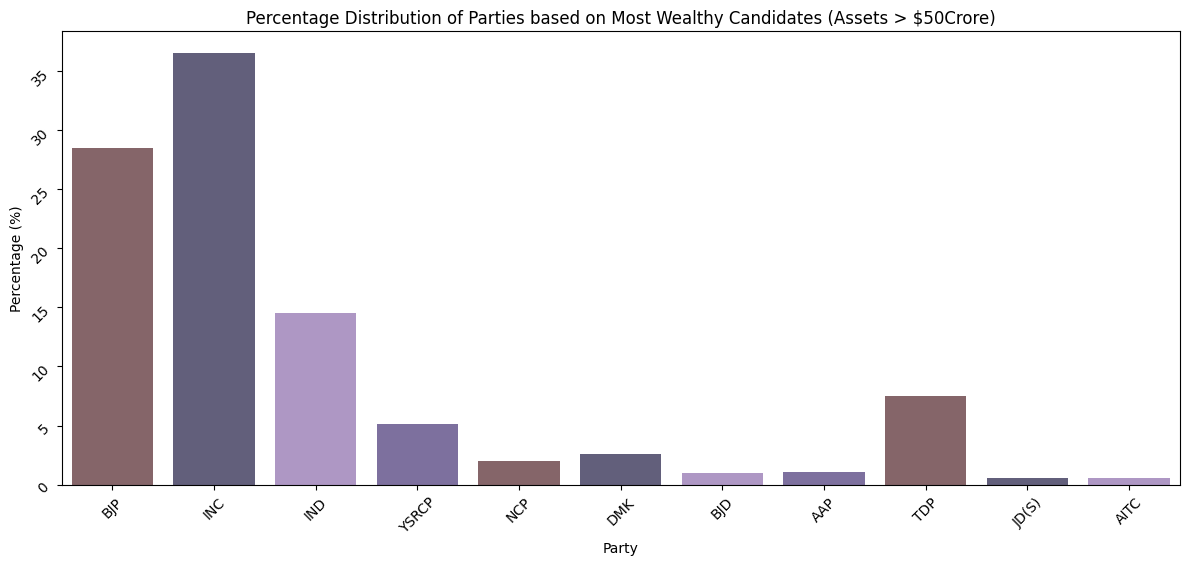

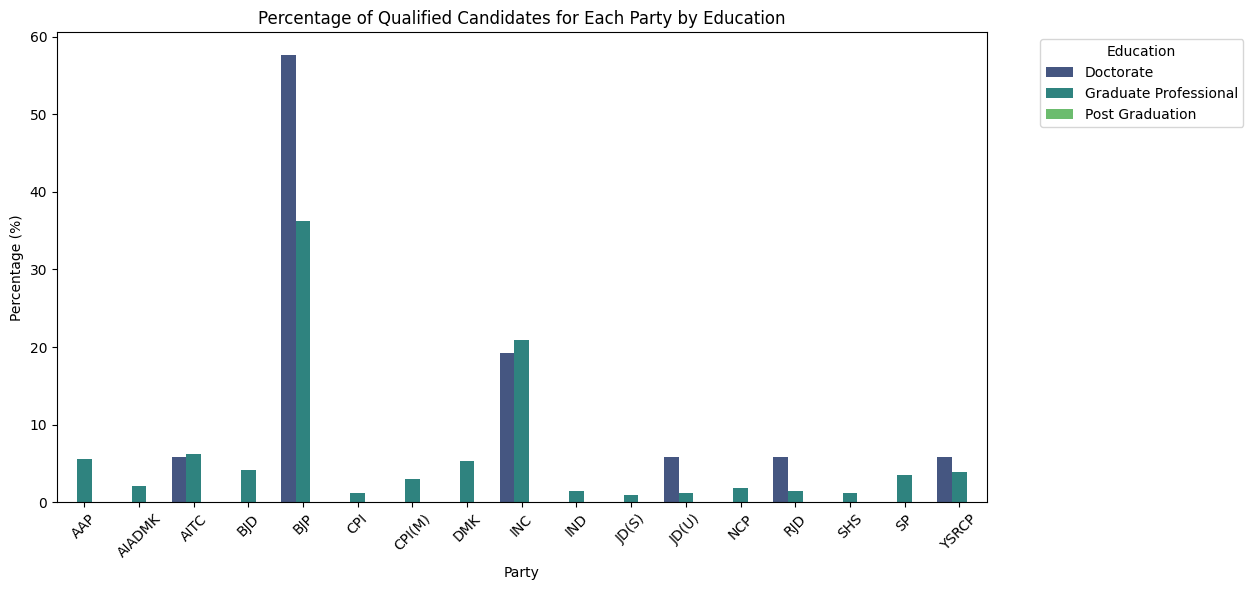

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X is your preprocessed DataFrame without the 'Candidate' and 'Constituency ∇' columns
# Also assuming 'Criminal Case', 'Total Assets', and 'Party' columns exist in X
custom_colors_blue_white = ['#1F77B4', '#AEC6CF', '#4A90E2', '#D0E9FF'] 
custom_colors = ['#8B5F65', '#5E5A80', '#AE8FCC', '#7A68A6'] 
# Calculate the percentage distribution for the 'Criminal Case' and 'Total Assets' columns

threshold = 6  # Example threshold in percentage (adjust as needed)

criminal_candidates = X[X['Criminal Case'] > threshold]
total_most_criminalrecords = criminal_candidates['Criminal Case'].sum()
# Calculate the percentage of assets held by each party's wealthy candidates
criminal_candidates['Criminal Case Percentage'] = (
    criminal_candidates.groupby('Party')['Criminal Case'].transform('sum') / total_most_criminalrecords * 100
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=criminal_candidates, x='Party', y='Criminal Case Percentage', 
            order=criminal_candidates['Party'].value_counts().index)
plt.title(f'Percentage Distribution of Parties based on Candidates with Most Criminal Records (> {threshold})')
plt.xlabel('Party')
plt.ylabel('Percentage (%)')
plt.yticks(rotation=45)  # Rotate y ticks to make them fit better
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusted tight layout
plt.show()

# Define a threshold for wealth
threshold = 5# Example threshold in currency (adjust as needed)
X['Total Assets'] = X['Total Assets'].apply(lambda x: float(x))
X['Total Assets Crores']=X['Total Assets']/100000000
# Filter the data to include only candidates with assets greater than the threshold
wealthy_candidates = X[X['Total Assets Crores'] > threshold]
# Calculate the total assets of all wealthy candidates
total_wealthy_assets = wealthy_candidates['Total Assets Crores'].sum()
# Calculate the percentage of assets held by each party's wealthy candidates
wealthy_candidates['Total Assets Percentage'] = (
    wealthy_candidates.groupby('Party')['Total Assets Crores'].transform('sum') / total_wealthy_assets * 100
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=wealthy_candidates, x='Party', y='Total Assets Percentage', 
            order=wealthy_candidates['Party'].value_counts().index, palette=custom_colors)
plt.title('Percentage Distribution of Parties based on Most Wealthy Candidates (Assets > $50Crore)')
plt.xlabel('Party')
plt.ylabel('Percentage (%)')
plt.yticks(rotation=45)  # Rotate y ticks to make them fit better
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjusted tight layout
plt.show()

qualified_education = ['Doctorate', 'Graduate Professional', 'Post Graduation']

# Filter the data to include only candidates with qualified education
qualified_candidates = X_with_education[X_with_education['Education'].isin(qualified_education)]

# Grouping by 'Education' and counting the occurrences
education_count = qualified_candidates.groupby('Education').size().reset_index(name='Education Count')

# Grouping by 'Party' and 'Education' and counting the occurrences
party_education_count = qualified_candidates.groupby(['Party', 'Education']).size().reset_index(name='Count')

# Merge the education count and party education count DataFrames on 'Education'
merged_count = pd.merge(party_education_count, education_count, on='Education')

# Calculate the percentage of each education qualification for each party
merged_count['Percentage'] = (merged_count['Count'] / merged_count['Education Count']) * 100

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(data=merged_count, x='Party', y='Percentage', hue='Education', 
            hue_order=qualified_education, palette='viridis')
plt.title('Percentage of Qualified Candidates for Each Party by Education')
plt.xlabel('Party')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')  # Positioning the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusted tight layout to fit the legend
plt.show()

